Monte Carlo Simulation
======================

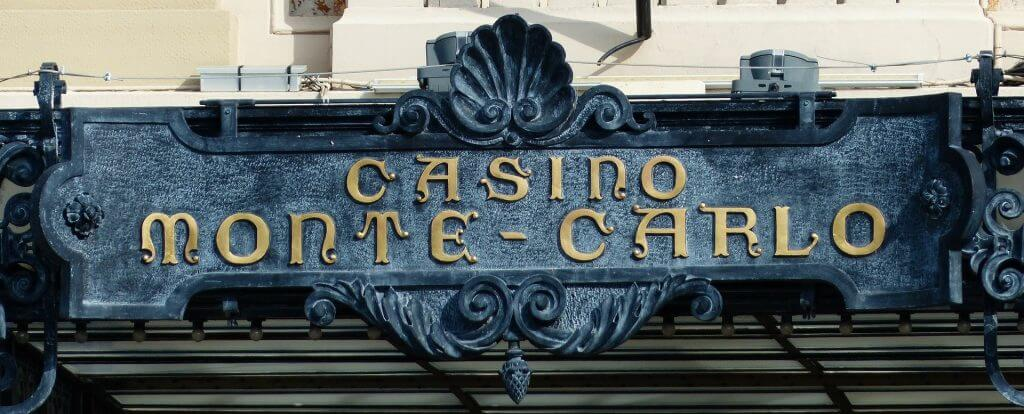

Monte Carlo simulation is a general term for introducing the notion of uncertainty into statistical estimations.

In [1]:
import numpy as np
import pandas as pd

Let's say we really want to visit a casino to have some fun gambling.   We want to figure out what game to play when we arrive and set out to analyze the chance of winning each.

We'll start with roulette.  After some research, we find that the casino's wheels have these characteristics.   We can use a random number between 1 and numbers_on the wheel to determine the outcome of any roll.  For example:

    numbers_on_wheel = 100
    losing_numbers = 2                                 # The '0' and '00' results
    red_numbers = 50                                   
    black_numbers = numbers_on_wheel - losing_numbers - red_numbers
    
We'll bet on red.    
    
In this example, 1 and 2 would lose.   A roll or 3-53 would be red (win).  54-100 would be black (lose).

For starters, let's say there are is no '0' or '00' on the wheel.   So we have:

In [ ]:
numbers_on_wheel = 100
losing_numbers = 0                                 
red_numbers = 50                                    
black_numbers = numbers_on_wheel - losing_numbers - red_numbers

OK.  We've implemented the parameters of the game.  Now we need code to operationalize it.

Note that this function is very atomic.  

In [45]:
def roulette_roll(verbose=True):
    
    # Use the random() library to generate an outcome
    roll = np.random.randint(1, numbers_on_wheel)
    
    # Interpret the outcome per the rules for this casino's roulette wheel
    if roll > losing_numbers and roll < red_numbers + losing_numbers + 1:
        
        # The 'verbose' bit lets us silence the code when in production.
        if verbose:  
            print(f"The roll was {roll:>3}.  We Win!")
            
        # By default functions return None (which evaluates to False if asked)    
        return True
    
    else:
        if verbose:
            print(f"The roll was {roll:>3}.  We lose :-(" )
    

OK. We have our game set up so we can play.   

Let's try our luck:

In [46]:
for _ in range(5):
    roulette_roll()

The roll was  36.  We Win!
The roll was  20.  We Win!
The roll was  26.  We Win!
The roll was  36.  We Win!
The roll was  27.  We Win!


Let's now put the roulette wheel into the casino.   

The casino will have a dealer who spins the wheel and handles the bets.

Each turn, we'll make the same bet.   If we win, that amount gets added to our bank.  Otherwise our bank decreases by the amount bet.

In [81]:
# This is the first laywer of wrapping.  We have a named parameter for each element of the system we
#   may want to tweak - including the elements of the wrapped function (just 'verbose' here).

def gaming_session(bank=100, bet=1, games_per_session=3, verbose=False):
    games_so_far = 0
    wins = 0
    initial_bank = bank
    
    # Play a games and account for results
    while games_so_far < games_per_session:
        if roulette_roll(verbose): 
            bank += bet
            wins += 1
        else:
            bank -= bet
        if verbose:
            print(f"Bank: {bank}")
            
        games_so_far += 1
    
    if verbose:
        print(f"We played {games_per_session} won {wins} ({wins/games_per_session*100:.2f}%)  ") 
    
    # Return average win (or loss)
    return (initial_bank - bank ) / games_per_session
            

In [82]:
gaming_session(100, 1, 3)

-0.3333333333333333

Now we can wrap an individual gaming session for one player into a casino full of players.

In [92]:
# This is the second layer of wrapping.   Note how this sets verbose for gaming_session(), 
#    which passes it through to roulette_roll().

verbose = False

def multi_player(players=10, bank=100, bet=1, games_per_session=3, verbose=verbose):
    players_so_far = 0
    results = []
    while players_so_far < players:
        results.append(gaming_session(bank, bet, games_per_session, verbose=verbose))
        players_so_far += 1
        
    return results

Finally, we'll set up some code to call the multi_player() routine and capture the results.

In [104]:
#  This is the outer layer of wrapping.   We set the parameters that will feed into multi_player() ..
#     .. which sends to gaming_session() .. which sends them to roulette_roll().

# Parameters for this run
players = 200
bank = 100
games_per_session = 30
bet = 1
verbose = False

# Capture the aggregated results
results = multi_player(players=players, bank=bank, bet=bet,
                       games_per_session=games_per_session, verbose=verbose)

if verbose:
    print(f"Winning percent for each player:\n\n{results}")

Let's have a look at the results.

This shows the average winnings.  For a $1 bet, this is also the 'percent profit' for each player.


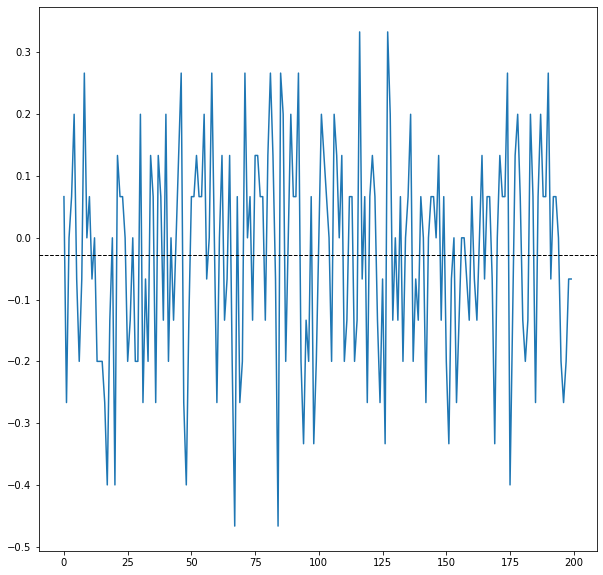

In [105]:
import matplotlib.pyplot as plt
 
avg_list = np.array(results)
plt.figure(figsize=(10,10))
plt.plot(avg_list)
plt.axhline(np.array(avg_list).mean(), color='k', linestyle='dashed', linewidth=1)

### import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.neighbors import KernelDensity

# Plot a 1D density example
N = 100
np.random.seed(1)
#X = np.concatenate((np.random.normal(0, 1, int(0.3 * N)),
#                    np.random.normal(5, 1, int(0.7 * N))))[:, np.newaxis]


X_plot = np.linspace(-5, 10, 1000)[:, np.newaxis]

true_dens = (0.3 * norm(0, 1).pdf(X_plot[:, 0])
             + 0.7 * norm(5, 1).pdf(X_plot[:, 0]))
true_dens = true_dens*200
3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
true_dens = (0.3 * norm(35, 5).pdf(X_plot[:, 0])
             + 0.7 * norm(60, 5).pdf(X_plot[:, 0]))
33333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333true_dens = true_dens*200
3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
fig, ax = plt.subplots()3333333333333333
ax.fill(X_plot[:, 0], true_dens, fc='black', alpha=0.2,333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
        label='input distribution')



#ax.text(6, 0.38, "N={0} points".format(N))
33333333333333333333333333333333333333333333333333333333333333333
#ax.legend(loc='upper left')
#ax.plot(X[:, 0], -0.005 - 0.01 * np.random.random(X.shape[0]), '+k')

ax.set_xlim(-4, 9)
#ax.set_ylim(-0.02, 0.4)
plt.show()

In [ ]:
for kernel in ['epanechnikov', 'tophat', 'gaussian']:
    kde = KernelDensity(kernel=kernel, bandwidth=0.5).fit(X)
    log_dens = kde.score_samples(X_plot)
    ax.plot(X_plot[:, 0], np.exp(log_dens), '-',
            label="kernel = '{0}'".format(kernel))